<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Neural-Network-Class" data-toc-modified-id="Neural-Network-Class-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Neural Network Class</a></span></li><li><span><a href="#QSAR-aquatic-toxicity-Data-Set" data-toc-modified-id="QSAR-aquatic-toxicity-Data-Set-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>QSAR aquatic toxicity Data Set</a></span></li><li><span><a href="#Grading" data-toc-modified-id="Grading-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Grading</a></span></li><li><span><a href="#Check-In" data-toc-modified-id="Check-In-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check-In</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>

# Neural Network Class

* A3.3: *Modified `A3grader.tar` to correctly grade the `error_trace` value.  It now assumes you use the following function for the `error_convert_f`:

        def error_convert(err):
            if T.shape[1] == 1:
                return np.sqrt(err) * self.stand_params['Tstds']
            else:
                # Can't unstandardize err if more than one network output
                return np.sqrt(err)

* A3.2: *Added `A3grader.py` and additional requirements involving application of your `NeuralNetwork` class to a specific data set.*
* A3.1: *Added some details on specifications of required functions and many examples of running your implementation.*

You will define a new class named `NeuralNetwork` that constructs a neural network with any number of hidden layers.  To train the neural network, you will use our `optimizers.py` code. Use this updated version: [optimizers.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/optimizers.tar).  Your class must implement at least the following functions. Lecture Notes 07 provide examples of some of the code in the section about using `Optimizers` on which you can base your implementation.

* `__init__(self, n_inputs, n_hiddens_list, n_outputs)`: 
* `__repr__(self):`
* `make_weights(self):` called from constructor `__init__`
* `initialize_weights(self):` called from constructor `__init__`
* `train(self, X, T, n_epochs, learning_rate, method='adam', verbose=True):` `method` can be 'sgd', 'adam', or 'scg'. Must first calculate standarization parameters, stored in `stand_params` dictionary, and standardize `X` and `T`.  Import `optimizers.py` and use these optimizers in this `train` function. Use the `tanh` activation function.
* `use(self, X, return_hidden_layer_outputs=False):` standardizes X then calculates the output of the network by calling `forward` and unstandardizing the network output. Returns just the output of the last layer. If `return_hidden_layer_outputs` is `True`, return two things, the output of the last layer and a list of outputs from each hidden layer.
* `get_error_trace(self):` just returns the `error_trace`

#### Suman Bhatta

### Assignment 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
floatPrecision = sys.float_info.epsilon



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
floatPrecision = sys.float_info.epsilon

# import the Optimizer code
import optimizers as opt

class NeuralNetwork():
    """ Class to work with Neural Network.
    """

    def __init__(self, n_inputs, n_hiddens_list, n_outputs):
        """ Initialize the class.
        """
        self.n_inputs = n_inputs
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs = n_outputs
        self.all_weights = None
        self.n_layer_size = []
        self.Ws = []
        #self.Z_list = []
        self.Gs = []
        self.error_trace = []
        self.all_gradients = None
        self.stand_params = {}
        self.n_layers = len(n_hiddens_list)

        def make_weights():
            """ Make weights.
            """          
            n_x = 1 + self.n_inputs
            for h in self.n_hiddens_list:
                self.n_layer_size.append(n_x * h)
                n_x = h + 1
            # Append the last layer size 
            self.n_layer_size.append(n_x * self.n_outputs)

            # Make numpy vector of all weights and initialize it to zeros
            n_weights = sum(self.n_layer_size)
            self.all_weights = np.zeros(n_weights)
            # Initialize the gradiant vectors to zeros
            self.all_gradients = np.zeros(n_weights)

        def initialize_weights():
            """ Initialize the weights
            """
            h = self.n_hiddens_list
            n_x = 1 + self.n_inputs

            id1 = 0
            id2 = id1 + self.n_layer_size[0]

            for i in range(len(h)):
                # Make views and initialize
                self.Ws.append(self.all_weights[id1:id2].reshape(n_x, h[i]))
                # Initialize weights
                self.Ws[i][:] = np.random.uniform(-1, 1, size=(n_x, h[i])) / np.sqrt(n_x)

                # make views for gradient
                self.Gs.append(self.all_gradients[id1:id2].reshape(n_x, h[i]))
                #self.Gs[i][:] = np.zeros_like(self.Ws[i][:])
                id1 = id2
                id2 = id1 + self.n_layer_size[i+1]
                n_x = h[i] + 1


            # Last weight
            self.Ws.append(self.all_weights[id1:id2].reshape(n_x, self.n_outputs))
            self.Ws[i+1][:] = np.random.uniform(-1, 1, size=(n_x, self.n_outputs)) / np.sqrt(n_x)

            # Last views to gradient
            self.Gs.append(self.all_gradients[id1:id2].reshape(n_x, self.n_outputs))

        # Call functions
        make_weights()
        initialize_weights()

    def __repr__(self):
        return "NeuralNetwork(n_inputs={}, n_hiddens_list={}, n_outputs={})".format(
                                    self.n_inputs, self.n_hiddens_list, self.n_outputs)


    def forward(self, Xst):
        """ Compute Yst from forward pass
        """
        # Generate output from first layer Z0
        Y_list = [np.tanh(self.add_ones(Xst) @ self.Ws[0])]

        for w in self.Ws[1:-1]:
            Y_list.append(np.tanh(self.add_ones(Y_list[-1]) @ w))

        Y_list.append(self.add_ones(Y_list[-1]) @ self.Ws[-1])
        return Y_list

    def backward(self, Xst, Tst):
        """ Compute gradient by back pass through the network
        """
        n_samples = Xst.shape[0]
        n_outputs = Tst.shape[1]

        Ys = self.forward(Xst)
   
        # The last element of the Ys list is the Outputs
        delta = -2*(Tst - Ys[-1]) /  (n_samples * n_outputs)

        # Run the loop in reverse
        # Exclude the last element of Ws
        gs = []
        for Y, W in zip(Ys[-2::-1], self.Ws[::-1]):
            #print(gs)
            gs.append(self.add_ones(Y).T @ delta)
            delta = (delta @ W[1:, :].T) * (1 - Y ** 2)

        # Calculate the final (first) gradient using Xst and delta 
        # from the previous pass
        gs.append(self.add_ones(Xst).T @ delta)
        # Reverse the gradient list since gradient is calculated in
        # reverse order
        gs.reverse()


        for i in range(len(self.n_hiddens_list) + 1):
            # Assign correct values of gradients
            self.Gs[i][:] = gs[i][:]

        return(self.all_gradients)

    def mse(self, Xst, Tst):
        Yst = self.forward(Xst)
        return(np.mean((Tst - Yst[-1]) ** 2))
    
    def add_ones(self, X):
        return np.insert(X, 0, 1, axis=1)

    def train(self, X, T, n_epochs, learning_rate, method='adam', verbose=True):
        """ Train the neural network.
        """

        # Store standardization parameters in dictionary stand_params.
        self.stand_params = self.calc_standardize_parameters(X, T)
        # Standardize X and T.
        Xst = self.standardize_X(X)
        Tst = self.standardize_T(T)

        def error_convert(err):
            if T.shape[1] == 1:
                 return np.sqrt(err) * self.stand_params['Tstds']
            else:
               # Can't unstandardize err if more than one network output
               return np.sqrt(err)

        optimizer = opt.Optimizers(self.all_weights)

        if method == 'sgd':
            self.error_trace = optimizer.sgd(self.mse, self.backward, [Xst, Tst], n_epochs, learning_rate,
                                             error_convert_f=error_convert)
        elif method == 'adam':
            self.error_trace = optimizer.adam(self.mse, self.backward, [Xst, Tst], n_epochs, learning_rate,
                                            error_convert_f=error_convert)
        elif method == 'scg':
            self.error_trace = optimizer.scg(self.mse, self.backward, [Xst, Tst], n_epochs, learning_rate,
                                            error_convert_f=error_convert)
        else:
            print('method must be ''sgd'', ''adam'', or ''scg''.')

    def use(self, X, return_hidden_layer_outputs=False):
        """ Compute the unstandardized X and T
        """
        # Standardize inputs X
        Xst = self.standardize_X(X)
        # Calculate outputs of each layer.
        Yst = self.forward(Xst)
        if return_hidden_layer_outputs == True:
            # Unstandardize output of output layer
            return self.unstandardize_T(Yst[-1]), Yst[:-1]
        else:
            return self.unstandardize_T(Yst[-1])

    def get_error_trace(self):
        """ Get the error tracing.
        """
        return(self.error_trace)

    def calc_standardize_parameters(self, X, T):
        """ Calculate parameters to standardize X and T
        """
        Xmeans = X.mean(axis=0)
        Xstds = X.std(axis=0)
        Tmeans = T.mean(axis=0)
        Tstds = T.std(axis=0)
        self.stand_params= {'Xmeans': Xmeans, 'Xstds': Xstds,
                'Tmeans': Tmeans, 'Tstds': Tstds}
        return(self.stand_params)

    def standardize_X(self, X):
        return (X - self.stand_params['Xmeans']) / self.stand_params['Xstds']

    def unstandardize_X(self, Xst):
        return Xst * self.stand_params['Xstds'] + self.stand_params['Xmeans']

    def standardize_T(self, T):
        return (T - self.stand_params['Tmeans']) / self.stand_params['Tstds']

    def unstandardize_T(self, Tst):
        return Tst * self.stand_params['Tstds'] + self.stand_params['Tmeans']


run() function to train a `NeuralNetwork` using a particular method and values for the number of epochs and learning rate.

In [3]:
def run(method, n_epochs, learning_rate=0):
    
    n_samples = 30
    Xtrain = np.linspace(0., 20.0, n_samples).reshape((n_samples, 1))
    Ttrain = 0.2 + 0.05 * (Xtrain) + 0.4 * np.sin(Xtrain / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

    Xtest = Xtrain + 0.1 * np.random.normal(size=(n_samples, 1))
    Ttest = 0.2 + 0.05 * (Xtest) + 0.4 * np.sin(Xtest / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

    n_inputs = Xtrain.shape[1]
    n_hiddens_list = [50, 20, 20]
    n_outputs = Ttrain.shape[1]

    nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
    nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method=method, verbose=False)

    def rmse(Y, T):
        error = T - Y
        return np.sqrt(np.mean(error ** 2))
    
    def error_convert(err):
        if T.shape[1] == 1:
            return np.sqrt(err) * self.stand_params['Tstds']
        else:
          # Can't unstandardize err if more than one network output
          return np.sqrt(err)

    Ytrain = nnet.use(Xtrain)
    rmse_train = rmse(Ytrain, Ttrain)
    Ytest = nnet.use(Xtest)
    rmse_test = rmse(Ytest, Ttest)

    print(f'Method: {method}, RMSE: Train {rmse_train:.2f} Test {rmse_test:.2f}')

    
    plt.figure(1, figsize=(10, 10))
    plt.clf()

    n_plot_rows = nnet.n_layers + 1
    ploti = 0

    ploti += 1
    plt.subplot(n_plot_rows, 1, ploti)
    plt.plot(nnet.get_error_trace())
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')

    ploti += 1
    plt.subplot(n_plot_rows, 1, ploti)
    plt.plot(Xtrain, Ttrain, 'o', label='Training Data')
    plt.plot(Xtest, Ttest, 'o', label='Testing Data')
    X_for_plot = np.linspace(0, 20, 100).reshape(-1, 1)
    Y, Zs = nnet.use(X_for_plot, return_hidden_layer_outputs=True)
    plt.plot(X_for_plot, Y, label='Neural Net Output')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')

    for layeri in range(nnet.n_layers - 2, -1, -1):
        ploti += 1
        plt.subplot(n_plot_rows, 1, ploti)
        plt.plot(X_for_plot, Zs[layeri])
        plt.xlabel('X')
        plt.ylabel(f'Outputs from Layer {layeri}')
        
    return nnet

sgd: Epoch 400 Error=0.16124
sgd: Epoch 800 Error=0.14798
sgd: Epoch 1200 Error=0.13836
sgd: Epoch 1600 Error=0.14392
sgd: Epoch 2000 Error=0.12604
sgd: Epoch 2400 Error=0.12635
sgd: Epoch 2800 Error=0.12518
sgd: Epoch 3200 Error=0.12319
sgd: Epoch 3600 Error=0.12176
sgd: Epoch 4000 Error=0.12028
Method: sgd, RMSE: Train 0.12 Test 0.26


NeuralNetwork(n_inputs=1, n_hiddens_list=[50, 20, 20], n_outputs=1)

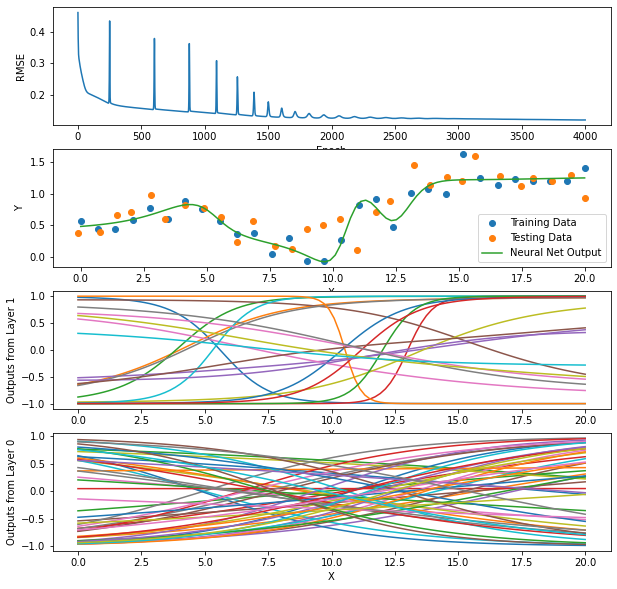

In [4]:
run('sgd', 4000, 0.1)

#### Discussion
The network was run and gradiants were mimimised using SGDs method. The RMSE initially jumps up and down and later after around 1500 steps gradually decreases. The Neural network output is fitting the training data nicely where as it does not properly fit the testing data.

Adam: Epoch 200 Error=0.17115
Adam: Epoch 400 Error=0.10396
Adam: Epoch 600 Error=0.09319
Adam: Epoch 800 Error=0.09036
Adam: Epoch 1000 Error=0.08966
Adam: Epoch 1200 Error=0.08895
Adam: Epoch 1400 Error=0.08957
Adam: Epoch 1600 Error=0.08875
Adam: Epoch 1800 Error=0.08868
Adam: Epoch 2000 Error=0.08865
Method: adam, RMSE: Train 0.09 Test 0.29


NeuralNetwork(n_inputs=1, n_hiddens_list=[50, 20, 20], n_outputs=1)

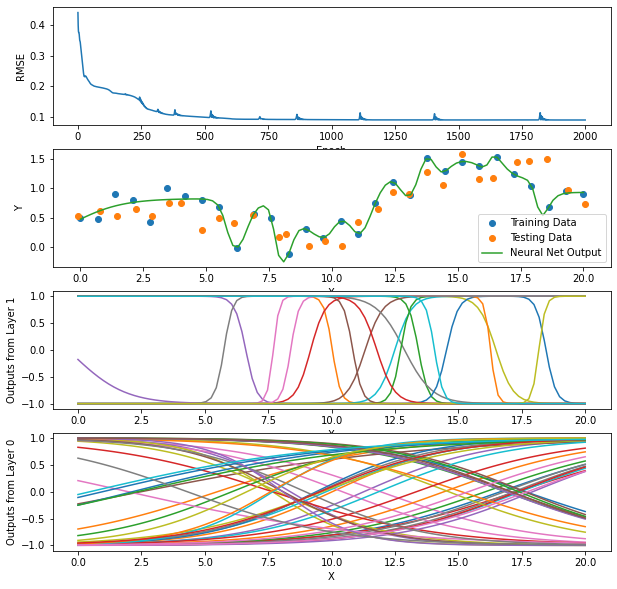

In [5]:
run('adam', 2000, 0.01)

SCG: Epoch 199 Error=0.09672
SCG: Epoch 399 Error=0.05843
SCG: Epoch 599 Error=0.04719
SCG: Epoch 799 Error=0.03085
SCG: Epoch 999 Error=0.00458
SCG: Epoch 1199 Error=0.00065
SCG: Epoch 1399 Error=0.00018
SCG: Epoch 1599 Error=0.00001
SCG: Epoch 1799 Error=0.00000
Method: scg, RMSE: Train 0.00 Test 0.25


NeuralNetwork(n_inputs=1, n_hiddens_list=[50, 20, 20], n_outputs=1)

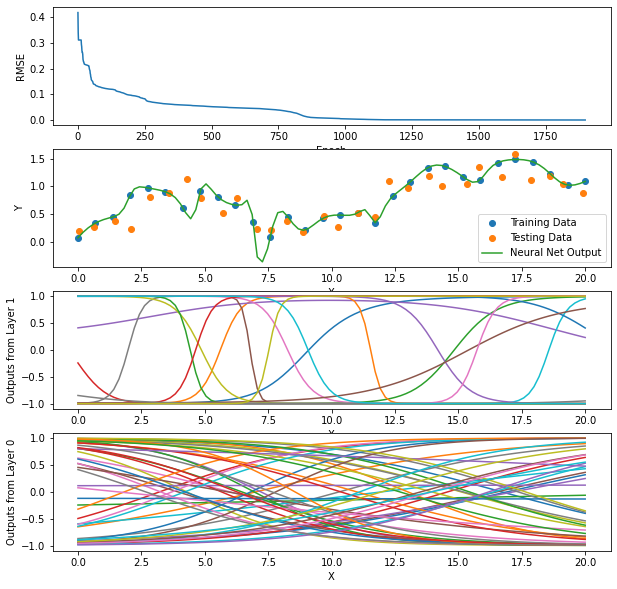

In [6]:
run('scg', 2000)

#  QSAR aquatic toxicity Data Set

Download the QSAR data set from [this UCI ML Repository site](https://archive.ics.uci.edu/ml/datasets/QSAR+aquatic+toxicity). It consists of eight measurements of water quality that may affect a ninth measurement, of aquatic toxicity towards [Daphnia Magna](https://en.wikipedia.org/wiki/Daphnia_magna#:~:text=Daphnia%20magna%20is%20a%20small,Northern%20Hemisphere%20and%20South%20Africa.).

Your job is to
* read this data into a numpy array,
* randomly shuffle the order of the rows in this data array (`np.random.shuffle`)
* take the first 500 rows as training data and the remaining rows as testing data,
* assign the first eight columns to `Xtrain` and `Xtest`, and the last column to `Ttrain` and `Ttest`,
* do some experimentation with different values of `n_hiddens_list`, `n_epochs` and `learning_rate` for the `sgd` and `adam` methods, and with different values of `n_hiddens_list`, `n_epochs` for `scg`, which does not use the `learning_rate`.
* using the parameter values (`n_hiddens_list`, `n_epochs` and `learning_rate`) that you find produce the lowest RMSE on test data for each method, create plots for each method that include the `error_trace`, the training data targets and predictions by the neural network, and the testing data targets and predictions by the neural network. The differrent methods may use different parameter values.

Describe your results with at least 10 sentences.

In [7]:
# Dowload the QSAR data
!wc qsar_aquatic_toxicity.csv

  546   546 22903 qsar_aquatic_toxicity.csv


In [8]:
import pandas as pd
# Read the data into pandas dataframe
datadf = pd.read_csv('qsar_aquatic_toxicity.csv', delimiter=';', header=None)



In [9]:
# Give names to the data columns
names = ('TPSA', 'SAacc', 'H-050', 'MLOGP', 'RDCHI', 'GATS1p', 'nN', 'C-40', 'LC50')
datadf.columns = names


In [10]:
# get the data values
data = datadf.values
# we can also use following command since it is simple text file with data dilimited by ;
# data = np.loadtxt('qsar_aquatic_toxicity.csv', delimiter=';')
data.shape


(546, 9)

In [11]:
# shuffle the data in place
np.random.shuffle(data)

In [12]:
# USe first 500 rows as training data and remainig as test data
Xtrain = data[:500, :-1]
Ttrain = data[:500, -1:]

Xtest = data[500:, :-1]
Ttest = data[500:, -1:]

In [13]:
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((500, 8), (500, 1), (46, 8), (46, 1))

In [14]:
%%capture capt
def run_QSAR(method, n_epochs_list, n_h_list, learning_rate_list=[0]):
    # Run the QSAR data for various parameter. Get the RMSE after each run
    # and find the minimum RMSE value
    Xtrain = data[:500, :-1]
    Ttrain = data[:500, -1:]
    Xtest = data[500:, :-1]
    Ttest = data[500:, -1:]
    
    n_inputs = Xtrain.shape[1]
    n_hiddens_list = n_h_list
    n_outputs = Ttrain.shape[1]
    
    
    def rmse(Y, T):
        error = T - Y
        return np.sqrt(np.mean(error ** 2))
    
    def error_convert(err):
        if T.shape[1] == 1:
            return np.sqrt(err) * self.stand_params['Tstds']
        else:
          # Can't unstandardize err if more than one network output
          return np.sqrt(err)
        

    
    rmse_list = []
    for n_epochs in n_epochs_list:
        for n_hiddens_list in n_h_list:
            for learning_rate in learning_rate_list:  
                # Train the network for each set of epochs, hidden_layers and learning_rate

                nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
                nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method=method, verbose=False)
    
                Ytrain = nnet.use(Xtrain)
                rmse_train = rmse(Ytrain, Ttrain)
                Ytest = nnet.use(Xtest)
                rmse_test = rmse(Ytest, Ttest)
                
                # Save the RMSE
                rmse_list.append([method, n_epochs, rmse_train, rmse_test, n_hiddens_list, learning_rate])
    
    # Find the minimum RMSE from list of RMSEs
    sorted_rmse_list = sorted(rmse_list, key=lambda x: x[3])
    print("Method epochs  rmse_train rmse_test, n_hidens_list, learning rate")
    # Display top 10 minimun RMSE test
    for min_rmse in sorted_rmse_list[0:10]:
        print(min_rmse);

    return(sorted_rmse_list[0])
    


In [15]:
# Avoids all the output prints to the cell console
#%%capture capt

# Make list of parameters to try on all methods
epoch_list = [100, 1000, 1500, 2000]
hidden_list = [[50], [10,10,10], [5,5,5], [5,2,10]]
learning_rate_list = [0.1, 0.01, 0.5, 0.001]


# Run all three methods for various parameters and save the paramterers for min RMSE
param_list_adam = run_QSAR('adam', epoch_list, hidden_list, learning_rate_list)
param_list_sgd = run_QSAR('sgd', epoch_list, hidden_list, learning_rate_list)
param_list_scg = run_QSAR('scg', epoch_list, hidden_list, learning_rate_list);




Adam: Epoch 50 Error=1.01516
Adam: Epoch 100 Error=0.84495
Adam: Epoch 150 Error=0.71142
Adam: Epoch 200 Error=0.63484
Adam: Epoch 250 Error=0.55609
Adam: Epoch 300 Error=0.55758
Adam: Epoch 350 Error=0.48265
Adam: Epoch 400 Error=0.52342
Adam: Epoch 450 Error=0.42816
Adam: Epoch 500 Error=0.41432
Adam: Epoch 50 Error=1.12414
Adam: Epoch 100 Error=1.01705
Adam: Epoch 150 Error=0.87484
Adam: Epoch 200 Error=0.77107
Adam: Epoch 250 Error=0.69529
Adam: Epoch 300 Error=0.63873
Adam: Epoch 350 Error=0.59817
Adam: Epoch 400 Error=0.56188
Adam: Epoch 450 Error=0.53233
Adam: Epoch 500 Error=0.50929
Adam: Epoch 50 Error=1.15426
Adam: Epoch 100 Error=0.81202
Adam: Epoch 150 Error=0.73421
Adam: Epoch 200 Error=0.66869
Adam: Epoch 250 Error=0.62673
Adam: Epoch 300 Error=0.59377
Adam: Epoch 350 Error=0.56231
Adam: Epoch 400 Error=0.53575
Adam: Epoch 450 Error=0.68107
Adam: Epoch 500 Error=0.56939
Adam: Epoch 50 Error=1.32191
Adam: Epoch 100 Error=1.20102
Adam: Epoch 150 Error=1.16700
Adam: Epoch 20

Adam: Epoch 700 Error=1.08016
Adam: Epoch 800 Error=1.05372
Adam: Epoch 900 Error=1.03013
Adam: Epoch 1000 Error=1.00699
Adam: Epoch 100 Error=0.96787
Adam: Epoch 200 Error=0.97780
Adam: Epoch 300 Error=0.93670
Adam: Epoch 400 Error=0.93711
Adam: Epoch 500 Error=0.92477
Adam: Epoch 600 Error=0.91426
Adam: Epoch 700 Error=0.91031
Adam: Epoch 800 Error=0.92537
Adam: Epoch 900 Error=0.91854
Adam: Epoch 1000 Error=0.90133
Adam: Epoch 100 Error=1.09484
Adam: Epoch 200 Error=1.03295
Adam: Epoch 300 Error=0.99496
Adam: Epoch 400 Error=0.97220
Adam: Epoch 500 Error=0.95708
Adam: Epoch 600 Error=0.95240
Adam: Epoch 700 Error=0.94888
Adam: Epoch 800 Error=0.94623
Adam: Epoch 900 Error=0.94433
Adam: Epoch 1000 Error=0.93949
Adam: Epoch 100 Error=1.57918
Adam: Epoch 200 Error=1.57915
Adam: Epoch 300 Error=1.57915
Adam: Epoch 400 Error=1.57912
Adam: Epoch 500 Error=1.57912
Adam: Epoch 600 Error=1.69751
Adam: Epoch 700 Error=1.46366
Adam: Epoch 800 Error=1.33324
Adam: Epoch 900 Error=1.30822
Adam: E

Adam: Epoch 1500 Error=1.19440
Adam: Epoch 1750 Error=1.24153
Adam: Epoch 2000 Error=1.24424
Adam: Epoch 2250 Error=1.22795
Adam: Epoch 2500 Error=1.21460
Adam: Epoch 250 Error=1.14109
Adam: Epoch 500 Error=1.07254
Adam: Epoch 750 Error=0.98410
Adam: Epoch 1000 Error=0.89488
Adam: Epoch 1250 Error=0.82285
Adam: Epoch 1500 Error=0.76727
Adam: Epoch 1750 Error=0.71646
Adam: Epoch 2000 Error=0.65990
Adam: Epoch 2250 Error=0.62311
Adam: Epoch 2500 Error=0.59274
Adam: Epoch 250 Error=0.87735
Adam: Epoch 500 Error=0.78003
Adam: Epoch 750 Error=0.78524
Adam: Epoch 1000 Error=0.76779
Adam: Epoch 1250 Error=0.78144
Adam: Epoch 1500 Error=0.73578
Adam: Epoch 1750 Error=0.72011
Adam: Epoch 2000 Error=0.72502
Adam: Epoch 2250 Error=0.72712
Adam: Epoch 2500 Error=0.74766
Adam: Epoch 250 Error=0.96124
Adam: Epoch 500 Error=0.86188
Adam: Epoch 750 Error=0.84364
Adam: Epoch 1000 Error=0.83466
Adam: Epoch 1250 Error=0.83541
Adam: Epoch 1500 Error=0.82200
Adam: Epoch 1750 Error=0.81588
Adam: Epoch 2000 

/home/sbhatta/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/sbhatta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in square
/home/sbhatta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: overflow encountered in matmul
/home/sbhatta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in multiply


sgd: Epoch 150 Error=nan
sgd: Epoch 200 Error=nan
sgd: Epoch 250 Error=nan
sgd: Epoch 300 Error=nan
sgd: Epoch 350 Error=nan
sgd: Epoch 400 Error=nan
sgd: Epoch 450 Error=nan
sgd: Epoch 500 Error=nan
sgd: Epoch 50 Error=1.62981
sgd: Epoch 100 Error=1.51355
sgd: Epoch 150 Error=1.43672
sgd: Epoch 200 Error=1.38572
sgd: Epoch 250 Error=1.35141
sgd: Epoch 300 Error=1.32783
sgd: Epoch 350 Error=1.31111
sgd: Epoch 400 Error=1.29882
sgd: Epoch 450 Error=1.28943
sgd: Epoch 500 Error=1.28196
sgd: Epoch 50 Error=1.27291
sgd: Epoch 100 Error=1.17400
sgd: Epoch 150 Error=1.13991
sgd: Epoch 200 Error=1.12395
sgd: Epoch 250 Error=1.10995
sgd: Epoch 300 Error=1.09664
sgd: Epoch 350 Error=1.08191
sgd: Epoch 400 Error=1.07719
sgd: Epoch 450 Error=1.05757
sgd: Epoch 500 Error=1.04580
sgd: Epoch 50 Error=1.59505
sgd: Epoch 100 Error=1.51377
sgd: Epoch 150 Error=1.39728
sgd: Epoch 200 Error=1.29954
sgd: Epoch 250 Error=1.25506
sgd: Epoch 300 Error=1.23474
sgd: Epoch 350 Error=1.22052
sgd: Epoch 400 Error

sgd: Epoch 200 Error=1.42558
sgd: Epoch 300 Error=1.33636
sgd: Epoch 400 Error=1.28123
sgd: Epoch 500 Error=1.24139
sgd: Epoch 600 Error=1.21517
sgd: Epoch 700 Error=1.19662
sgd: Epoch 800 Error=1.18294
sgd: Epoch 900 Error=1.17326
sgd: Epoch 1000 Error=1.16673
sgd: Epoch 100 Error=1.30797
sgd: Epoch 200 Error=1.20416
sgd: Epoch 300 Error=1.13980
sgd: Epoch 400 Error=1.11127
sgd: Epoch 500 Error=1.09384
sgd: Epoch 600 Error=1.08328
sgd: Epoch 700 Error=1.07329
sgd: Epoch 800 Error=1.05725
sgd: Epoch 900 Error=1.04642
sgd: Epoch 1000 Error=1.04353
sgd: Epoch 100 Error=1.64059
sgd: Epoch 200 Error=1.62378
sgd: Epoch 300 Error=1.60661
sgd: Epoch 400 Error=1.58861
sgd: Epoch 500 Error=1.56961
sgd: Epoch 600 Error=1.54960
sgd: Epoch 700 Error=1.52878
sgd: Epoch 800 Error=1.50748
sgd: Epoch 900 Error=1.48616
sgd: Epoch 1000 Error=1.46533
sgd: Epoch 200 Error=1.11204
sgd: Epoch 400 Error=1.04784
sgd: Epoch 600 Error=0.99915
sgd: Epoch 800 Error=0.95927
sgd: Epoch 1000 Error=0.92979
sgd: Epoch

sgd: Epoch 500 Error=1.22570
sgd: Epoch 750 Error=1.16747
sgd: Epoch 1000 Error=1.14860
sgd: Epoch 1250 Error=1.14055
sgd: Epoch 1500 Error=1.13434
sgd: Epoch 1750 Error=1.12872
sgd: Epoch 2000 Error=1.12356
sgd: Epoch 2250 Error=1.11878
sgd: Epoch 2500 Error=1.11418
sgd: Epoch 250 Error=1.22024
sgd: Epoch 500 Error=1.07667
sgd: Epoch 750 Error=1.03155
sgd: Epoch 1000 Error=0.99219
sgd: Epoch 1250 Error=0.94141
sgd: Epoch 1500 Error=0.90627
sgd: Epoch 1750 Error=0.88399
sgd: Epoch 2000 Error=0.87344
sgd: Epoch 2250 Error=0.87000
sgd: Epoch 2500 Error=0.86778
sgd: Epoch 250 Error=1.58928
sgd: Epoch 500 Error=1.55455
sgd: Epoch 750 Error=1.51623
sgd: Epoch 1000 Error=1.47568
sgd: Epoch 1250 Error=1.43651
sgd: Epoch 1500 Error=1.40217
sgd: Epoch 1750 Error=1.37423
sgd: Epoch 2000 Error=1.35220
sgd: Epoch 2250 Error=1.33458
sgd: Epoch 2500 Error=1.31995
sgd: Epoch 250 Error=1.12596
sgd: Epoch 500 Error=1.08340
sgd: Epoch 750 Error=1.04672
sgd: Epoch 1000 Error=1.02353
sgd: Epoch 1250 Error

SCG: Epoch 899 Error=0.25643
SCG: Epoch 999 Error=0.24850
SCG: Epoch 99 Error=0.75143
SCG: Epoch 199 Error=0.55890
SCG: Epoch 299 Error=0.46087
SCG: Epoch 399 Error=0.40136
SCG: Epoch 499 Error=0.36490
SCG: Epoch 599 Error=0.33895
SCG: Epoch 699 Error=0.30312
SCG: Epoch 799 Error=0.28266
SCG: Epoch 899 Error=0.26816
SCG: Epoch 999 Error=0.25589
SCG: Epoch 99 Error=0.86599
SCG: Epoch 199 Error=0.65598
SCG: Epoch 299 Error=0.52490
SCG: Epoch 399 Error=0.45053
SCG: Epoch 499 Error=0.40427
SCG: Epoch 599 Error=0.37556
SCG: Epoch 699 Error=0.35765
SCG: Epoch 799 Error=0.34339
SCG: Epoch 899 Error=0.33187
SCG: Epoch 999 Error=0.32441
SCG: Epoch 99 Error=0.82298
SCG: Epoch 199 Error=0.63519
SCG: Epoch 299 Error=0.51335
SCG: Epoch 399 Error=0.44816
SCG: Epoch 499 Error=0.39452
SCG: Epoch 599 Error=0.36407
SCG: Epoch 699 Error=0.34886
SCG: Epoch 799 Error=0.33271
SCG: Epoch 899 Error=0.32043
SCG: Epoch 999 Error=0.31271
SCG: Epoch 99 Error=0.81910
SCG: Epoch 199 Error=0.57332
SCG: Epoch 299 Err

SCG: Epoch 1999 Error=0.81711
SCG: Epoch 199 Error=0.93948
SCG: Epoch 399 Error=0.88030
SCG: Epoch 599 Error=0.86517
SCG: Epoch 799 Error=0.85849
SCG: Epoch 999 Error=0.85023
SCG: Epoch 1199 Error=0.84565
SCG: Epoch 1399 Error=0.84344
SCG: Epoch 1599 Error=0.84215
SCG: Epoch 1799 Error=0.84075
SCG: Epoch 1999 Error=0.83959
SCG: Epoch 249 Error=0.50460
SCG: Epoch 499 Error=0.36744
SCG: Epoch 749 Error=0.28153
SCG: Epoch 999 Error=0.23821
SCG: Epoch 1249 Error=0.21331
SCG: Epoch 1499 Error=0.19486
SCG: Epoch 1749 Error=0.18485
SCG: Epoch 1999 Error=0.17755
SCG: Epoch 2249 Error=0.17333
SCG: Epoch 2499 Error=0.16994
SCG: Epoch 249 Error=0.56325
SCG: Epoch 499 Error=0.36852
SCG: Epoch 749 Error=0.28695
SCG: Epoch 999 Error=0.24913
SCG: Epoch 1249 Error=0.22674
SCG: Epoch 1499 Error=0.21219
SCG: Epoch 1749 Error=0.20330
SCG: Epoch 1999 Error=0.19498
SCG: Epoch 2249 Error=0.18928
SCG: Epoch 2499 Error=0.18414
SCG: Epoch 249 Error=0.51852
SCG: Epoch 499 Error=0.37067
SCG: Epoch 749 Error=0.29

In [16]:
# minimum RMSE test and paramters for ADAMs method
param_list_adam

['adam', 2500, 0.5926288812583198, 1.026979264839833, [10, 10, 10], 0.001]

In [17]:
#minimum RMSE test and paramters for SGDs method 
param_list_sgd

['sgd', 1000, 1.0629035658428043, 1.0906900908023214, [5, 5, 5], 0.1]

In [18]:
#minimum RMSE test and paramters for SCGs method 

param_list_scg

['scg', 500, 0.9081754396441922, 1.1094229499388868, [5, 2, 10], 0.01]

In [19]:
# Display the QSAR plots
# Train the network for the parameters which gives mimimun test RMSE
# Obtain the Error trace and plots
def run_show_plots(param_list, show_plots=False):
    method = param_list[0]
    n_epochs = param_list[1]
    n_hiddens_list = param_list[4]
    learning_rate = param_list[5]
    
    n_inputs = Xtrain.shape[1]
    n_hiddens_list = n_hiddens_list
    n_outputs = Ttrain.shape[1]

    nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
    nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method=method, verbose=False)

    def rmse(Y, T):
        error = T - Y
        return np.sqrt(np.mean(error ** 2))
    
    def error_convert(err):
        if T.shape[1] == 1:
            return np.sqrt(err) * self.stand_params['Tstds']
        else:
          # Can't unstandardize err if more than one network output
          return np.sqrt(err)

    Ytrain = nnet.use(Xtrain)
    rmse_train = rmse(Ytrain, Ttrain)
    Ytest = nnet.use(Xtest)
    rmse_test = rmse(Ytest, Ttest)

    print(f'Method: {method}, RMSE: Train {rmse_train:.2f} Test {rmse_test:.2f}')
    
    if show_plots:
        plt.figure(1, figsize=(10, 10))
        plt.clf()


        plt.subplot(3, 1, 1)
        plt.plot(nnet.get_error_trace())
       # plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.title("RMSE vs epochs")

        plt.subplot(3, 1, 2)
        plt.plot(Ttrain, 'o', label='Training Data') # Training data
        plt.plot(nnet.use(Xtrain), '-o', label='Prediction Data') # prediction
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Ttrain')
        plt.title("Train Data")

        
        # Test data plots
        plt.subplot(3, 1, 3)
        Y = nnet.use(Xtest)
        plt.plot(Ttest, 'o', label='Test data')
        plt.plot(nnet.use(Xtest), '-o', label='Test prediction')
        plt.legend()
        plt.xlabel('X')
        plt.ylabel('Ytest')
        plt.title("Test Data")
    return nnet


Adam: Epoch 250 Error=1.13788
Adam: Epoch 500 Error=1.03835
Adam: Epoch 750 Error=0.92169
Adam: Epoch 1000 Error=0.86613
Adam: Epoch 1250 Error=0.80974
Adam: Epoch 1500 Error=0.76303
Adam: Epoch 1750 Error=0.72637
Adam: Epoch 2000 Error=0.68619
Adam: Epoch 2250 Error=0.64914
Adam: Epoch 2500 Error=0.62322
Method: adam, RMSE: Train 0.62 Test 1.34


NeuralNetwork(n_inputs=8, n_hiddens_list=[10, 10, 10], n_outputs=1)

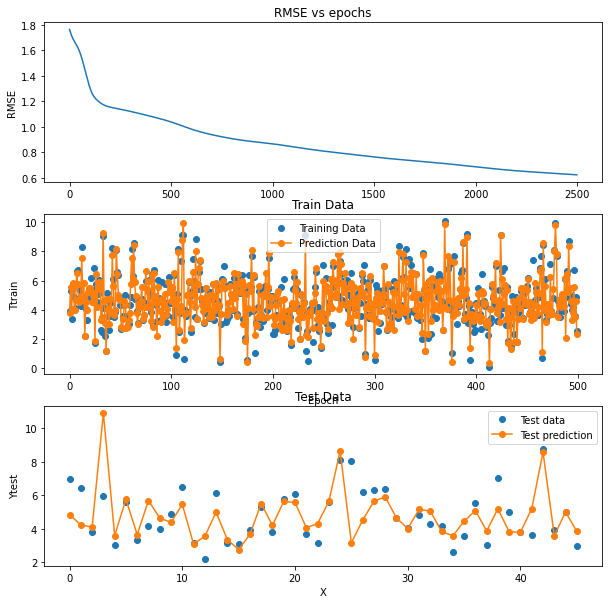

In [20]:
# Run for ADAM using parameters that gives lowest RMSE
# The error_trace is printed in the concole and plots are displayed
run_show_plots(param_list_adam, show_plots=True)


sgd: Epoch 100 Error=1.16450
sgd: Epoch 200 Error=1.11902
sgd: Epoch 300 Error=1.09550
sgd: Epoch 400 Error=1.08179
sgd: Epoch 500 Error=1.07018
sgd: Epoch 600 Error=1.05827
sgd: Epoch 700 Error=1.04843
sgd: Epoch 800 Error=1.05981
sgd: Epoch 900 Error=1.03849
sgd: Epoch 1000 Error=1.02859
Method: sgd, RMSE: Train 1.03 Test 1.09


NeuralNetwork(n_inputs=8, n_hiddens_list=[5, 5, 5], n_outputs=1)

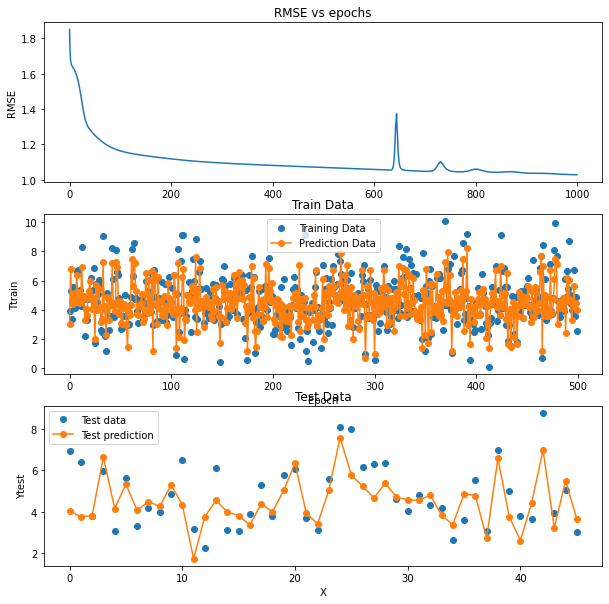

In [21]:
# Plot for SGD using parameters that gives lowest RMSE
# The error_trace is printed in the concole and plots are displayed
run_show_plots(param_list_sgd, show_plots=True)


SCG: Epoch 49 Error=1.08952
SCG: Epoch 99 Error=1.01619
SCG: Epoch 149 Error=0.97640
SCG: Epoch 199 Error=0.96194
SCG: Epoch 249 Error=0.95041
SCG: Epoch 299 Error=0.94078
SCG: Epoch 349 Error=0.93502
SCG: Epoch 399 Error=0.92870
SCG: Epoch 449 Error=0.92303
SCG: Epoch 499 Error=0.91222
Method: scg, RMSE: Train 0.91 Test 1.19


NeuralNetwork(n_inputs=8, n_hiddens_list=[5, 2, 10], n_outputs=1)

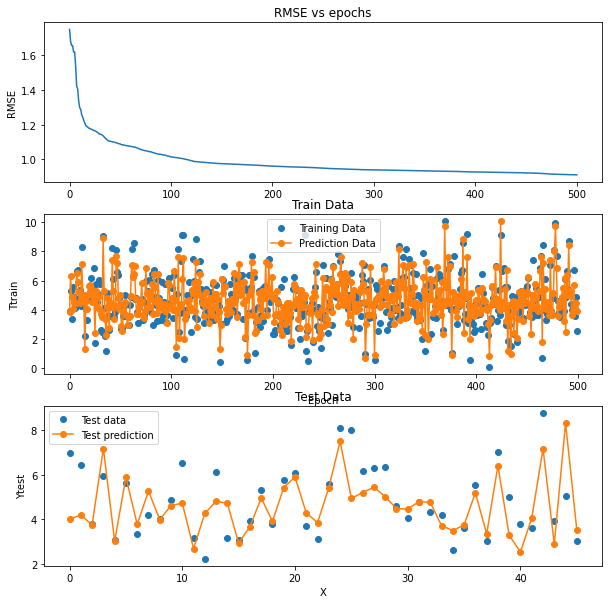

In [22]:
# Plot for SCG using parameters that gives lowest RMSE
# The error_trace is printed in the concole and plots are displayed
run_show_plots(param_list_scg, show_plots=True)


### Describe the result.
The QSAR data has 8 input columns and one output column. Initial 500 rows were used for training the network and remaining data were used as testing data. The Neural network was trained and rmse test were observed by varying number of hidden layers, learning rate and number of steps. The parameters for with the neural network gives minimum rmse test was used for analysis.
In general the RMSE results were observed minimum if we run the netwrok for large steps.But for most of the case if we run the  network for large number of layers the RMSE were minimum.

The prediction data obtained from the network is similar to the training data. Among three different methods
ADAM seems to produce better prediction data as seem in the second plot of ADAM second set of plots.
The RMSE test of obtained from SDG converges quickly and goes to minimum quickly compared to other methods.
This can be seen in the first plots of all three sets of plots.
    
The predicted test results has similar distribution to the test data in all the three methods, which can be seen in all three sets of plots.
    
Among all the three methods ADAM method shows better prediction data because the prediction data points are very close to test adat points. This can be seen in third plot of each set of plots.

The test rmse from SGD method is minimum. But the plot shows that middle part of the test data is fitted well but the later part of the data is not fitted properly. Some part of the data is over fitted where as other parts are under fitted.
Hence TPSA(Tot), SAacc, H-050, MLOGP, RDCHI, GATS1p, nN, C-040 can be used to predict the acute aquatic toxicity toward the Daphnia Magna using adams method using obtained paramters.


# Grading

Your notebook will be run and graded automatically. Test this grading process by first downloading [A3grader.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A3grader.tar) and extract `A3grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  The remaining 40 points will be based on other testing and the results you obtain and your discussions. 

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as 'Lastname-A3.ipynb' with 'Lastname' being your last name, and then save this notebook.

In [23]:
%run -i A3grader.py


======================= Code Execution =======================

More than one ipynb file found: ['Btest-A3.ipynb', 'Bhattaold-A3.ipynb']. Using first one.
Extracting python code from notebook named 'Btest-A3.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.
CRITICAL ERROR: Function named 'NeuralNetworks' is not defined
  Check the spelling and capitalization of the function name.

## Testing constructor ####################################################################

    nnet = NeuralNetwork(2, [5, 4], 3)
    W_shapes = [W.shape for W in nnet.Ws]


--- 5/5 points. W_shapes is correct value of [(3, 5), (6, 4), (5, 3)]

## Testing constructor ####################################################################

    G_shapes = [G.shape for G in nnet.Gs]


--- 5/5 points. G_shapes is correct value of [(3, 5), (6, 4), (5, 3)]

## Testing constructor ###################################################################

# Extra Credit

Earn one extra credit point by downloading a second, real data set and repeating the above experiments.